In [9]:
import torch

def dfdx_equation(x: torch.Tensor) -> torch.Tensor:
    """Derivative as per the equation."""
    return 5*(4*x**3 + x**2 - 2*x - 0.5)

In [10]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [11]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[0.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    return ode_loss + boundary_loss

In [12]:
from qadence import feature_map, hea, chain
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 3
depth = 3

# Feature map
fm = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable
observable = Z(0)

circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

In [13]:
n_epochs = 200
n_points = 10

xmin = -0.99
xmax = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)

    loss = loss_fn(inputs = x_train, model = model)
    loss.backward()
    optimizer.step()

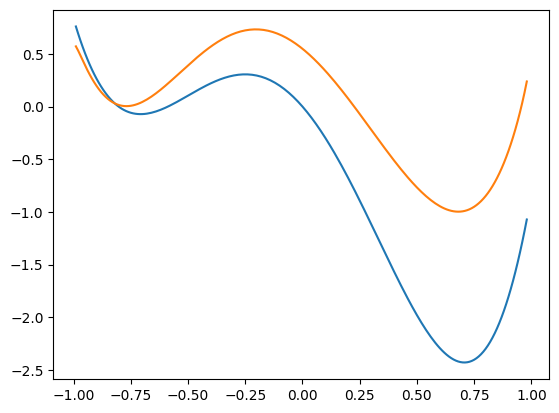

In [14]:
import matplotlib.pyplot as plt

def f_exact(x: torch.Tensor) -> torch.Tensor:
    return 5*(x**4 + (1/3)*x**3 - x**2 - 0.5*x)

x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution")
plt.plot(x_test, result_model, label = " Trained model")

In [15]:
from qadence import add

observable = add(Z(i) for i in range(n_qubits))

model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data
    x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)

    loss = loss_fn(inputs = x_train, model = model)
    loss.backward()
    optimizer.step()

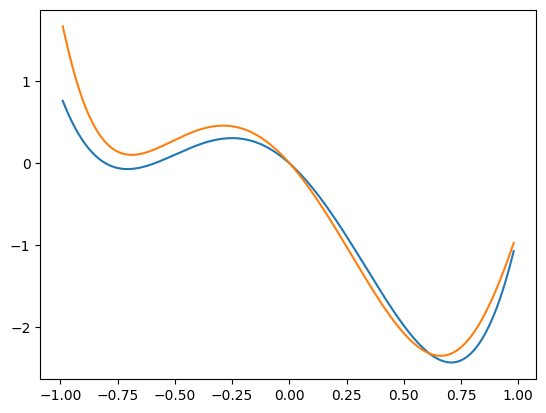

In [16]:
x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution")
plt.plot(x_test, result_model, label = "Trained model")